## Import Necessary Modules

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install wordcloud

In [ ]:
!pip install neattext

In [1]:
import boto3
import re
import string
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 100)

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, tokenization
import neattext as nt
import neattext.functions as nfx

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
get_ipython().magic('matplotlib inline')

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Read in Data

In [3]:
#Gather data from s3 bucket
bucketname = 'YOUR BUCKET NAME HERE'
filename = 'script_EDA_file.csv'

s3 = boto3.resource('s3')
s3.Bucket(bucketname).download_file(filename, '../../script_EDA_file.csv')

In [4]:
df = pd.read_csv("../../script_EDA_file.csv")

In [5]:
#Drop first column
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [6]:
#View data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1141 non-null   object
 1   text       1141 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


## Data Cleaning

In [7]:
#Remove unneccesary characters from text
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d' ]", ' ', x))

In [8]:
#Split scripts by words
df['text'] = df['text'].str.split()

In [9]:
#Create Movie title column
df["movie_title"] = df["file_name"].apply(lambda x: x.split(".")[0].replace("_", " "))

In [10]:
#Pull last couple of words from script to extract genre
df['Genres'] = df['text'].apply(lambda x: x[-40:])

In [11]:
# Separate Genre into a separate column

def pull_genre(column):
    newlst = []
    [newlst.append(column[i + 1]) for i, word in enumerate(column) if word == "Genres"]
    return newlst

df['genre'] = df['Genres'].apply(lambda x: pull_genre(x))

df.drop(columns = ['Genres'], axis = 1, inplace = True)

df['genre'] = df['genre'].apply(lambda x: x[0])

In [12]:
#Split Genre into Lists
def split_genres(genres):
    return re.sub( r"([A-Z])", r" \1", genres).split()

df['genre'] = df['genre'].apply(lambda x: split_genres(str(x)))

In [13]:
def remove_caps(text):
    regex = re.compile(r"(\b[A-Z]+\b)")
    caps = list(filter(regex.match, text))
    no_caps = [x for x in text if x not in caps]
    return no_caps

df['text'] = df['text'].apply(lambda x: remove_caps(x))

In [14]:
# Turn text column into strings for preprocessing purposes
df['text'] = df['text'].apply(lambda x: " ".join(x))

In [15]:
#Remove digits
def remove_digits(text):
    text = re.sub('\w*\d\w*', "", text)
    return text

df['text'] = df['text'].apply(remove_digits)

In [16]:
df.head()

,file_name,text,movie_title,genre
0,Beasts_of_No_Nation.txt,Written by Cary Joji Fukunaga Based on the novel by Uzodinma Iweala May The dialogue in this s...,Beasts of No Nation,"[Drama, War]"
1,Beauty_and_the_Beast.txt,Written by Stephen Chbosky Evan Spiliotopoulos Based on the Animated Film Beauty and the Beast ...,Beauty and the Beast,"[Family, Fantasy, Musical]"
2,Beavis_and_Butt-head_Do_America.txt,Beavis and Butt Head Do America by Mike Judge and Joe Stillman b b if window top top location hr...,Beavis and Butt-head Do America,"[Animation, Comedy]"
3,Beginners.txt,Written by Mike Mills single daisy stands in a vase in an empty kitchen clicks on the light to t...,Beginners,"[Comedy, Drama, Romance]"
4,Being_Human.txt,Written by Bill Forsyth January Warner Boulevard Burbank California All Rights Reserved and ...,Being Human,"[Comedy, Drama, Fantasy]"


### Multi-Label Binarizer

In [17]:
#binarize genre data
from sklearn.preprocessing import MultiLabelBinarizer

# Binarise labels
mlb = MultiLabelBinarizer()
expandedGenreData = mlb.fit_transform(df['genre'])
labelClasses = mlb.classes_


# Create a pandas.DataFrame from our output
expandedGenres = pd.DataFrame(expandedGenreData, columns=labelClasses)

In [19]:
#concat dataframes back together
df_concat = pd.concat([df, expandedGenres], axis=1)

In [20]:
df_concat.rename(columns={'Film': 'Film-Noir', 'Sci': 'Sci-Fi'}, inplace=True)

In [23]:
#Additional data cleaning using neattext library
def new_clean(words):
    docx = nt.TextFrame(words)
    docx.remove_stopwords(lang='en')
    docx.remove_multiple_spaces
    docx.remove_special_characters
    docx.remove_numbers
    docx.remove_puncts()
    docx.remove_custom_words(["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', "n't", 'takes', 'right'])
    docx.remove_custom_words(['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes'])
    docx.remove_custom_words(["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', 'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got', 'head', 'hand'])
    return docx

df_concat['text'] = df_concat['text'].apply(lambda x: new_clean(x))

In [30]:
# df_concat.to_csv("../../justincase.csv", index = False)

In [ ]:
# df_concat.to_csv("../../no_caps_script.csv", index = False)

In [28]:
#Delist text column for preprocessing purposes
# df['text'] = df['text'].apply(eval).apply(' '.join)
# df['text'].apply(eval).apply(' '.join)

# Turn text column into strings for preprocessing purposes
# df['text'].apply(lambda x: " ".join(x))

In [139]:
# df = pd.read_csv("../../justincase.csv")

### Removing Stop Words

In [28]:
df = pd.read_csv("../../no_caps_script.csv")

In [31]:
## setting stopwords and punctuations
import string, re

stop_words_list = stopwords.words('english')
stop_words_list += list(string.punctuation)
stop_words_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got', 'head', 'hand']
stop_words_list += ["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', "n't", 'takes', 'right']
stop_words_list += ['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes']

stop_words_set = set(stop_words_list)

In [32]:
# we can define a function that removes stopwords 
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words_set]
    return stopwords_removed 

# applying the above function to our text column
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
# df['text'].apply(lambda x: remove_stopwords(x))

In [34]:
df.to_csv("../../no_stop_words.csv", index = False)

### Stemming

In [37]:
df2 = pd.read_csv("../../no_stop_words.csv")

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [38]:
#Delist text column for preprocessing purposes
df2['text'] = df2['text'].apply(eval).apply(' '.join)

In [ ]:
# portstem = PorterStemmer()

In [ ]:
# # creating a list with all lemmatized outputs
# stemmed_output = []

# for listy in processed_data:
#     stemmed = ' '.join([portstem.stem(w) for w in listy])
#     stemmed_output.append(lemmed)

### Lemmitization

In [86]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("enters"))

enters


In [41]:
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

df2['text'] = df2['text'].apply(lemmatize_text)

In [43]:
df2.to_csv('../../lemm_data.csv', index = False)

### Frequency Distribution

In [44]:
df_lemm = pd.read_csv('../../lemm_data.csv')

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [46]:
df_lemm.head()

,file_name,text,movie_title,genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Beasts_of_No_Nation.txt,"['cary', 'joji', 'fukunaga', 'based', 'novel', 'uzodinma', 'iweala', 'dialogue', 'screenplay', 'faithful', 'form', 'novel', 'originally', 'lighter', 'form', 'nigerian', 'pidgin', 'english', 'known', 'krio', 'krio', 'dialect', 'lingua', 'franca', 'west', 'africa', 'gambia', 'cameroon', 'spoken', 'million', 'accented', 'starting', 'angle', 'plastic', 'exterior', 'screen', 'television', 'child', ...",Beasts of No Nation,"['Drama', 'War']",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Beauty_and_the_Beast.txt,"['stephen', 'chbosky', 'evan', 'spiliotopoulos', 'based', 'animated', 'film', 'beauty', 'beast', 'screenplay', 'linda', 'woolverton', 'august', 'resplendent', 'bespeaking', 'great', 'wealth', 'power', 'ground', 'stonework', 'immaculate', 'time', 'hidden', 'heart', 'france', 'handsome', 'young', 'prince', 'lived', 'beautiful', 'castle', 'single', 'clinging', 'rose', 'bush', 'stormy', 'spring', ...",Beauty and the Beast,"['Family', 'Fantasy', 'Musical']",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Beavis_and_Butt-head_Do_America.txt,"['beavis', 'butt', 'america', 'mike', 'judge', 'joe', 'stillman', 'window', 'location', 'href', 'location', 'href', 'mike', 'judge', 'joe', 'stillman', 'movie', 'begin', 'scene', 'people', 'screaming', 'horror', 'running', 'street', 'big', 'city', 'ground', 'shake', 'giant', 'footstep', 'piece', 'building', 'debris', 'falling', 'people', 'getting', 'crushed', 'power', 'line', 'coming', 'etc', ...",Beavis and Butt-head Do America,"['Animation', 'Comedy']",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beginners.txt,"['mike', 'mill', 'single', 'daisy', 'stand', 'vase', 'kitchen', 'click', 'light', 'closet', 'rack', 'parent', 'clothes', 'begin', 'box', 'marked', 'home', 'box', 'marked', 'thrift', 'oliver', 'enters', 'bathroom', 'flush', 'bottle', 'bottle', 'pill', 'liquid', 'toilet', 'struggle', 'old', 'toothbrush', 'hairbrush', 'bottle', 'tube', 'sink', 'stare', 'beat', 'throw', 'oliver', 'haul', 'trash', ...",Beginners,"['Comedy', 'Drama', 'Romance']",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Being_Human.txt,"['bill', 'forsyth', 'january', 'warner', 'boulevard', 'burbank', 'california', 'right', 'reserved', 'stared', 'sky', 'listened', 'cow', 'mooing', 'dreamily', 'distant', 'village', 'tried', 'understand', 'meant', 'sky', 'field', 'humming', 'telegraph', 'pole', 'felt', 'point', 'understanding', 'started', 'spin', 'lucid', 'languor', 'moment', 'intolerable', 'vladimir', 'nabokov', 'script', 'main...",Being Human,"['Comedy', 'Drama', 'Fantasy']",0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# df_lemm['text'].values

In [14]:
# script_text

In [86]:
#Delist text column for preprocessing purposes
# df_lemm['text'] = df_lemm['text'].apply(eval).apply(' '.join)

# df_lemm['text'] = df_lemm['text'].apply(lambda x: " ".join(x))

In [47]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=5, stop_words="english")
df_cv = cv.fit_transform(df_lemm.text)
df_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_lemm.movie_title
df_dtm

,aa,aaa,aaaa,aaaaa,aaaaaaaah,aaaaaaah,aaaaah,aaaah,aaaahhh,aaaahhhh,aaagh,aaah,aaahh,aaargh,aagh,aah,aahh,aahhh,aahs,aaron,ab,aback,abacus,abandon,abandoned,...,zippo,zis,zit,zo,zodiac,zoe,zoes,zoloft,zombie,zone,zoned,zoning,zonked,zoo,zoological,zoom,zoomed,zooming,zoot,zorro,zucchini,zulu,zurich,zwei,zy
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Beasts of No Nation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0
Beauty and the Beast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Beavis and Butt-head Do America,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Beginners,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Being Human,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Battle of Shaker Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Battle: Los Angeles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7,...,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
Bean,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
import pickle
# Let's pickle it for later use
df_dtm.to_pickle("../../dtm.pkl")

In [10]:
# def freqdist(ex):
#     fdist = nltk.FreqDist(ex)
#     for word in fdist:
#         print(f'{word}: {fdist[word]}')

In [12]:
freqdist(ex)

yo: 3
hey: 1
what's: 1
up: 2


In [21]:
# df_lemm['text'].apply(freqdist)

In [ ]:
# df3['freqdist'] = df3['text'].apply(freqdist)

## Visualizing Data

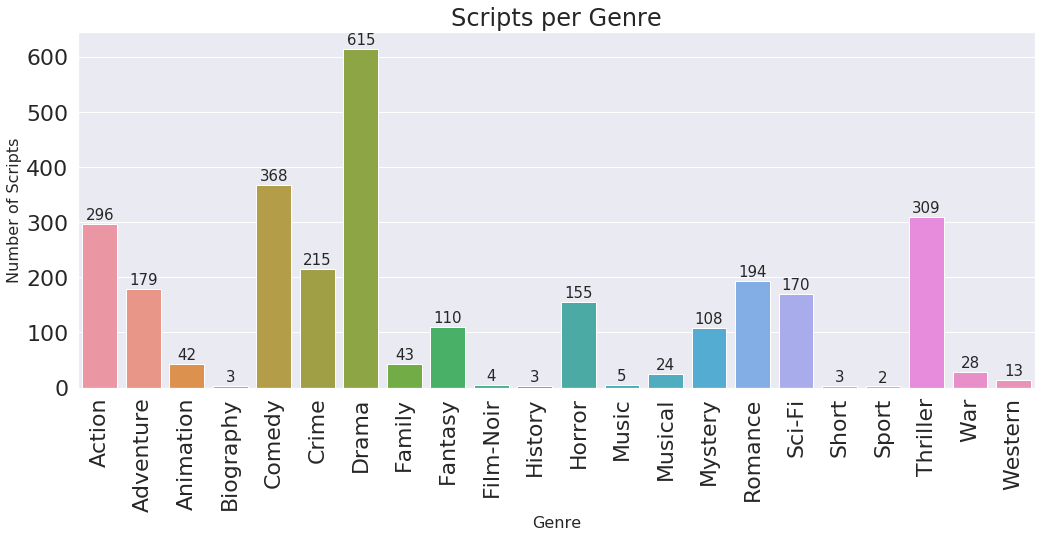

In [50]:
#Barplot for amount of scripts in each genre
categories = list(df_lemm.columns[4:].values)
sns.set(font_scale = 2, style = 'darkgrid')
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, df_lemm.iloc[:,4:].sum().values)
plt.title("Scripts per Genre", fontsize=24)
plt.ylabel('Number of Scripts', fontsize=16)
plt.xlabel('Genre', fontsize=16)

ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='center')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size = 15,
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.savefig('../../scripts_per_genre.png')
plt.show()

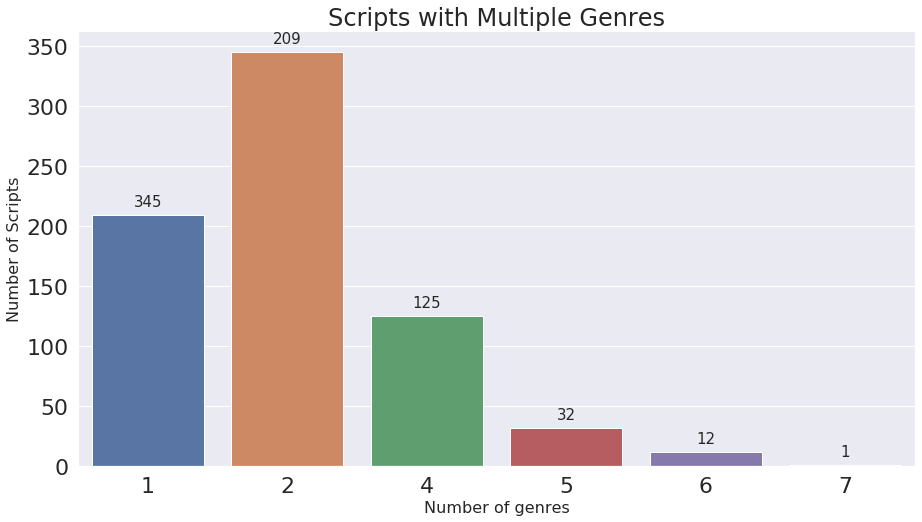

In [51]:
#Barplot for scripts that have multiple genres
rowSums = df_lemm.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Scripts with Multiple Genres")
plt.ylabel('Number of Scripts', fontsize=16)
plt.xlabel('Number of genres', fontsize=16)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, 
            label, ha='center', va='bottom', size=15)
    

plt.savefig('../../scripts_multiple_genre.png')
plt.show()

### Most Common Bar Graphs

In [65]:
df_drama = df_lemm[df_lemm['Drama']==1]
df_comedy = df_lemm[df_lemm['Comedy']==1]
df_action = df_lemm[df_lemm['Action']==1]
df_thriller = df_lemm[df_lemm['Thriller']==1]

In [66]:
drama_text = df_drama['text']
comedy_text = df_comedy['text']
action_text = df_action['text']
thriller_text = df_thriller['text']

In [68]:
script_drama = list(map(new_clean, drama_text))
script_comedy = list(map(new_clean, comedy_text))
script_action = list(map(new_clean, action_text))
script_thriller = list(map(new_clean, thriller_text))

In [119]:
#Delist text column for preprocessing purposes
# df_lemm['text'] = df_lemm['text'].apply(eval).apply(' '.join)
# script_drama.apply(lambda x: " ".join(x))

In [69]:
flat_drama = [sublist for sublist in script_drama]
flat_comedy = [sublist for sublist in script_comedy]
flat_action = [sublist for sublist in script_action]
flat_thriller = [sublist for sublist in script_thriller]

In [70]:
drama_token = nltk.word_tokenize(str(flat_drama))
comedy_token = nltk.word_tokenize(str(flat_comedy))
action_token = nltk.word_tokenize(str(flat_action))
thriller_token = nltk.word_tokenize(str(flat_thriller))

In [71]:
drama_freq = FreqDist(drama_token)
comedy_freq = FreqDist(comedy_token)
action_freq = FreqDist(action_token)
thriller_freq = FreqDist(thriller_token)

In [72]:
# Top 20 thriller words:

thriller_freq.most_common(25)

[('open', 11842),
 ('he', 11706),
 ('car', 11032),
 ('man', 10562),
 ('time', 9372),
 ('think', 8771),
 ('thats', 8713),
 ('walk', 8685),
 ('pull', 8488),
 ('start', 8137),
 ('way', 7940),
 ('stop', 7446),
 ('phone', 7157),
 ('beat', 7001),
 ('let', 6929),
 ('stand', 6875),
 ('cant', 6763),
 ('light', 6627),
 ('gun', 6430),
 ('window', 6417),
 ('guy', 6164),
 ('watch', 6125),
 ('smile', 6106),
 ('thing', 6015),
 ('tell', 5973)]

In [73]:
# create counts of satire and not satire with values and words
drama_bar_counts = [x[1] for x in drama_freq.most_common(25)]
drama_bar_words = [x[0] for x in drama_freq.most_common(25)]

comedy_bar_counts = [x[1] for x in comedy_freq.most_common(25)]
comedy_bar_words = [x[0] for x in comedy_freq.most_common(25)]

action_bar_counts = [x[1] for x in action_freq.most_common(25)]
action_bar_words = [x[0] for x in action_freq.most_common(25)]

thriller_bar_counts = [x[1] for x in thriller_freq.most_common(25)]
thriller_bar_words = [x[0] for x in thriller_freq.most_common(25)]

In [74]:
# set the color of our bar graphs
color = cm.winter_r(np.linspace(.4,.8, 30))

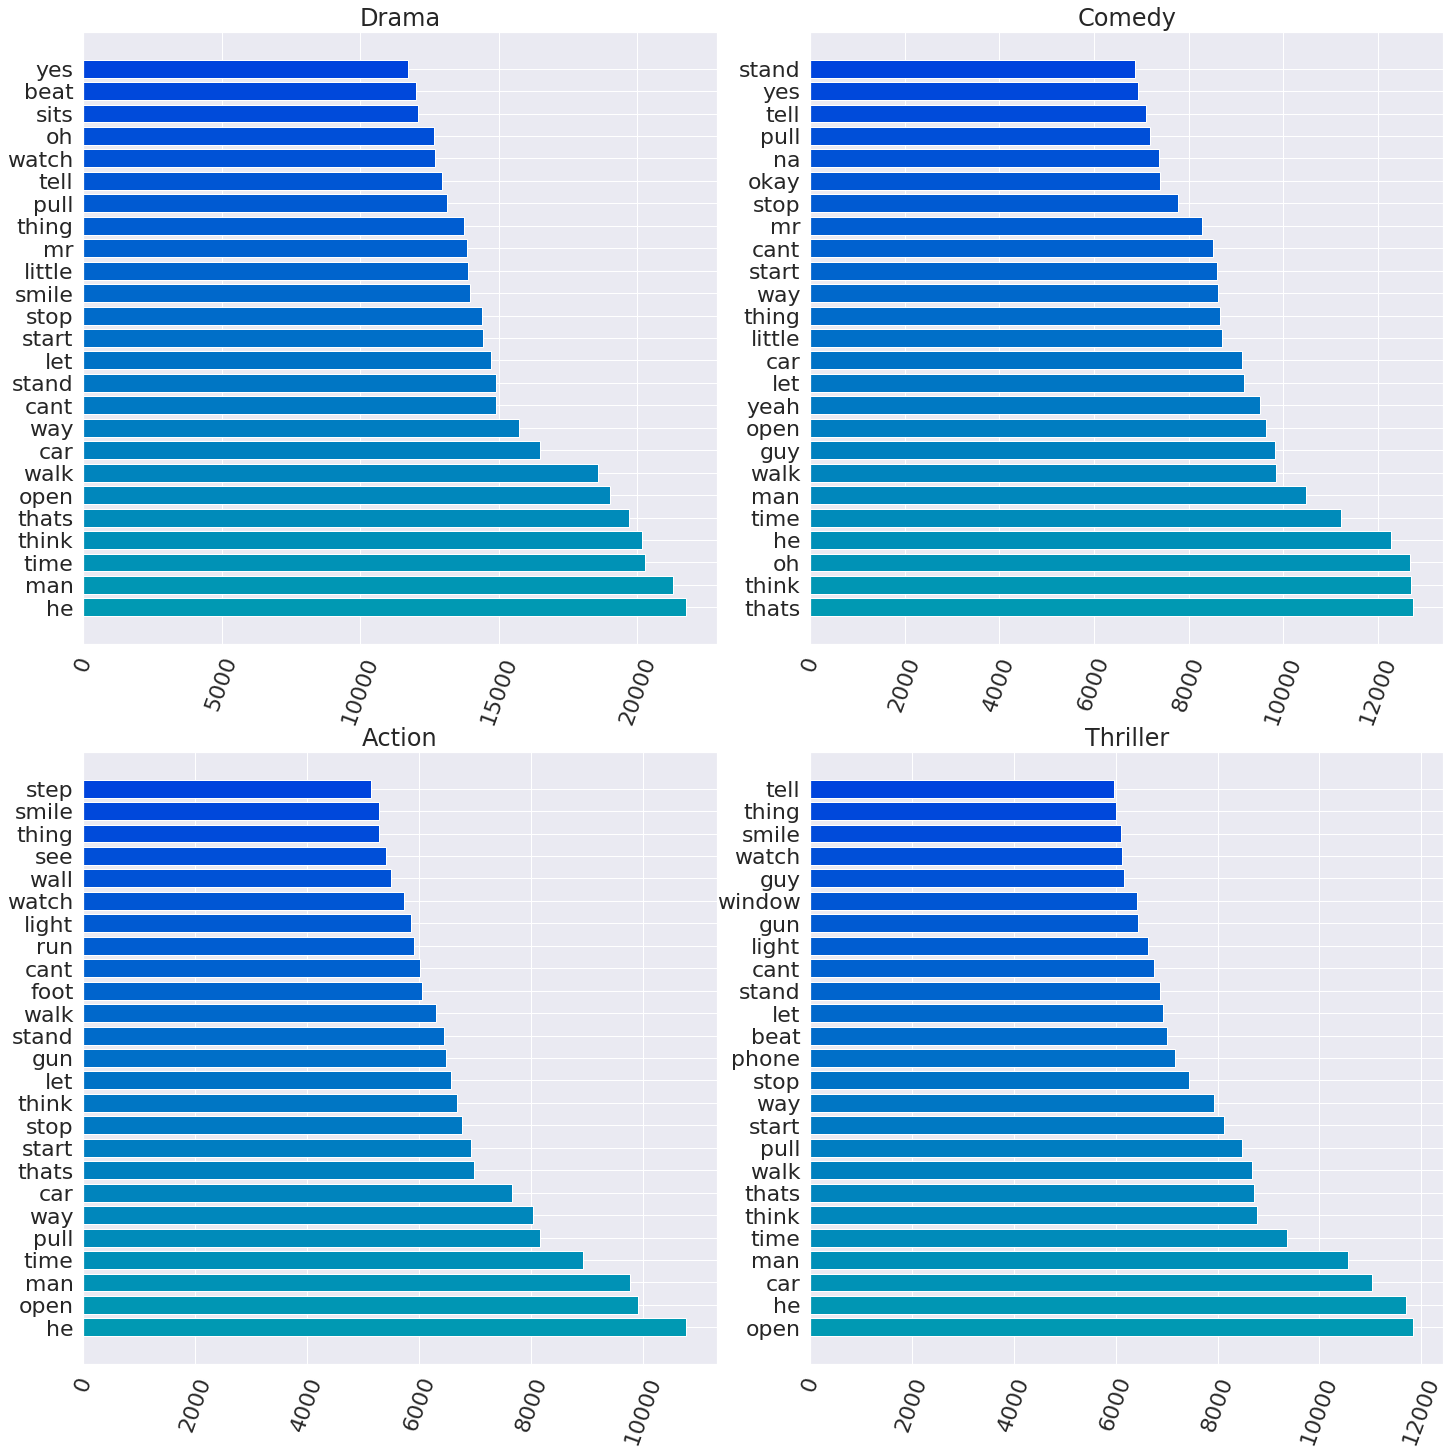

In [77]:
new_figure = plt.figure(figsize=(20,20))

ax = new_figure.add_subplot(221)
ax2 = new_figure.add_subplot(222)
ax3 = new_figure.add_subplot(223)
ax4 = new_figure.add_subplot(224)


# Generate a line plot on first axes
ax.barh(drama_bar_words, drama_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.barh(comedy_bar_words, comedy_bar_counts, color=color)

# Draw a scatter plot on 3rd axes
ax3.barh(action_bar_words, action_bar_counts, color=color)

# Draw a scatter plot on 4th axes
ax4.barh(thriller_bar_words, thriller_bar_counts, color=color)


ax.title.set_text('Drama')
ax2.title.set_text('Comedy')
ax3.title.set_text('Action')
ax4.title.set_text('Thriller')


for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)


plt.tight_layout(pad=0)
# plt.yscale()
plt.savefig('../../word_count_bar_graphs.png')

plt.show()

### Wordclouds

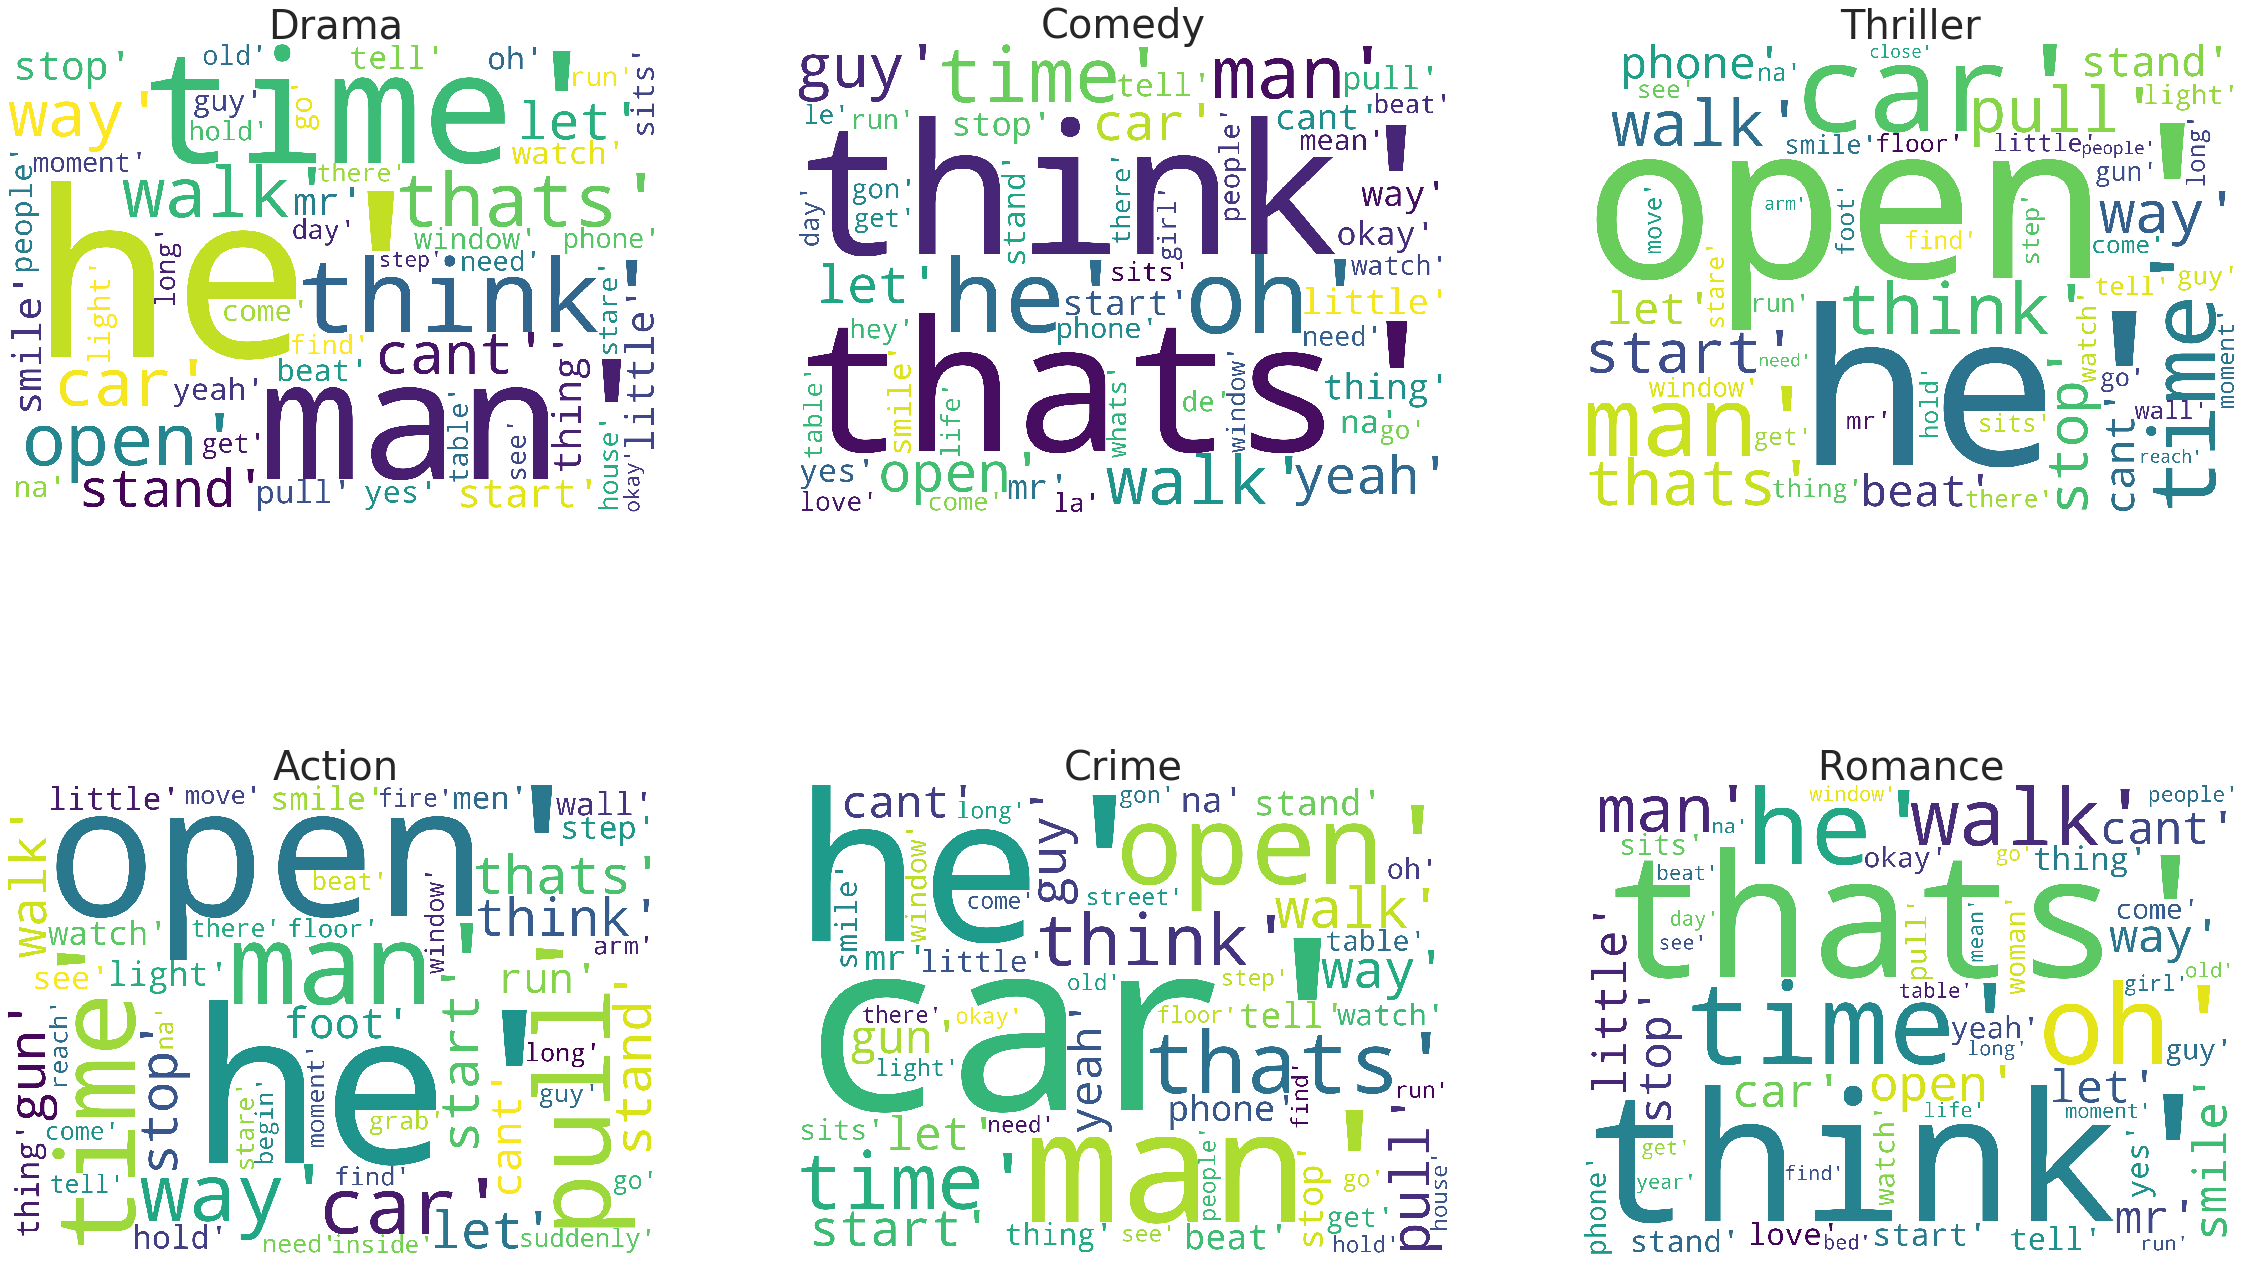

In [78]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# drama
subset = df_lemm[df_lemm.Drama==1]
text = [line for line in subset.text.values]
cloud_drama = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Drama",fontsize=40)
plt.imshow(cloud_drama)


# comedy
subset = df_lemm[df_lemm.Comedy==1]
text = [line for line in subset.text.values]
cloud_comedy = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Comedy",fontsize=40)
plt.imshow(cloud_comedy)



# Thriller
subset = df_lemm[df_lemm.Thriller==1]
text = [line for line in subset.text.values]
cloud_thriller = WordCloud(stopwords=STOPWORDS,
                           background_color='white',
                           collocations=False,
                           max_words=50,
                           width=2500,
                           height=1800).generate(str(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Thriller",fontsize=40)
plt.imshow(cloud_thriller)


# action
subset = df_lemm[df_lemm.Action==1]
text = [line for line in subset.text.values]
cloud_action = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Action",fontsize=40)
plt.imshow(cloud_action)


# crime
subset = df_lemm[df_lemm.Crime==1]
text = [line for line in subset.text.values]
cloud_crime = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Crime",fontsize=40)
plt.imshow(cloud_crime)


# romance
subset = df_lemm[df_lemm.Romance==1]
text = [line for line in subset.text.values]
cloud_romance = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          max_words=50,
                          width=2500,
                          height=1800).generate(str(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Romance",fontsize=40)
plt.imshow(cloud_romance)

plt.show()

### Train-Test-Split

In [58]:
df_lemm['text'] = df_lemm['text'].apply(nfx.remove_multiple_spaces)

In [59]:
script_corpus = df_lemm['text'].apply(nfx.clean_text)

In [60]:
X = script_corpus
y = df_lemm.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [62]:
print("X Train Shape:", X_train.shape)
print("Y Train Shape:", y_train.shape)
print("X Test Shape:", X_test.shape)
print("Y Test Shape:", y_test.shape)

X Train Shape: (855,)
Y Train Shape: (855, 22)
X Test Shape: (286,)
Y Test Shape: (286, 22)


In [97]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df_lemm, random_state=42, test_size=0.25, shuffle=True)

# print("Train Shape:", train.shape)
# print("Test Shape:", test.shape)

In [19]:
# train_text = train['text']
# test_text = test['text']

### TF-IDF

In [63]:
tfidf = TfidfVectorizer(ngram_range=(1,3), norm='l2')

tfidf_train_lem = tfidf.fit_transform(X_train)
tfidf_test_lem = tfidf.transform(X_test)

tfidf_train_lem

<855x11797036 sparse matrix of type '<class 'numpy.float64'>'
	with 16686215 stored elements in Compressed Sparse Row format>

In [64]:
non_zero_cols = tfidf_train_lem.nnz / float(tfidf_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 19516.040935672514
Percentage of columns containing ZERO: 0.998345682683712


In [59]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', stop_words=stop_words_set)
# vectorizer.fit(train_text)
# vectorizer.fit(test_text)

In [21]:
# X_train = vectorizer.transform(train_text)
# y_train = train.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

# X_test = vectorizer.transform(test_text)
# y_test = test.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

## Modeling

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier

In [81]:
# categories = list(df_lemm.columns.values)
# categories = categories[4:]
categories = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
print(categories)

['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


### Logistic Regression Pipeline

In [82]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting logistic regression model on train data
    LogReg_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(tfidf_test_lem)
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
#     print('F1 score is {}'.format(f1_score(test[category], prediction)))
#     print(classification_report(test[category], prediction))
    print("\n")

Processing Action scripts
Testing accuracy is 0.7412587412587412


Processing Adventure scripts
Testing accuracy is 0.8601398601398601


Processing Comedy scripts
Testing accuracy is 0.6573426573426573


Processing Crime scripts
Testing accuracy is 0.7902097902097902


Processing Drama scripts
Testing accuracy is 0.6783216783216783


Processing Fantasy scripts
Testing accuracy is 0.8951048951048951


Processing Horror scripts
Testing accuracy is 0.8566433566433567


Processing Mystery scripts
Testing accuracy is 0.9090909090909091


Processing Romance scripts
Testing accuracy is 0.8146853146853147


Processing Sci-Fi scripts
Testing accuracy is 0.8671328671328671


Processing Thriller scripts
Testing accuracy is 0.7167832167832168


CPU times: user 2.74 s, sys: 3.18 s, total: 5.92 s
Wall time: 5min 32s


In [83]:
print(len(y_test[category]))

286


In [84]:
print(len(prediction))

286


### Multinomial Naive Bayes Pipeline

In [86]:
%%time

# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])


for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting Naive Bayes model on train data
    NB_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(tfidf_test_lem)
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    print("\n")

Processing Action scripts
Testing accuracy is 0.7412587412587412


Processing Adventure scripts
Testing accuracy is 0.8601398601398601


Processing Comedy scripts
Testing accuracy is 0.6503496503496503


Processing Crime scripts
Testing accuracy is 0.7902097902097902


Processing Drama scripts
Testing accuracy is 0.6363636363636364


Processing Fantasy scripts
Testing accuracy is 0.8951048951048951


Processing Horror scripts
Testing accuracy is 0.8566433566433567


Processing Mystery scripts
Testing accuracy is 0.9090909090909091


Processing Romance scripts
Testing accuracy is 0.8146853146853147


Processing Sci-Fi scripts
Testing accuracy is 0.8671328671328671


Processing Thriller scripts
Testing accuracy is 0.7167832167832168


CPU times: user 15.2 s, sys: 5.95 s, total: 21.1 s
Wall time: 21.3 s


### Gaussian Naive Bayes

In [90]:
!pip install scikit-multilearn

In [91]:
%%time

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
GNB = BinaryRelevance(GaussianNB())

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting Naive Bayes model on train data
    GNB.fit(tfidf_train_lem, y_train[category])

    # calculating test accuracy
    prediction = GNB.predict(tfidf_test_lem)
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    print("\n")

Processing Action scripts


AttributeError: 'Series' object has no attribute 'reshape'